In [1]:
using DrWatson
@quickactivate

In [2]:
using main
using BlockDiagonals, LinearAlgebra, Plots, ProgressMeter
using Distributions, MCMCChains, Random

ProgressMeter.ijulia_behavior(:clear)
gr(fmt=:png)

Plots.GRBackend()

In [3]:
μ = [
    [2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], 
    [3.93, 8.82], [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], 
    [6.91, 5.81], [6.87, 5.40], [5.41, 2.65], [2.70, 7.88], 
    [4.98, 3.70], [1.14, 2.39], [8.33, 9.50], [4.93, 1.5], 
    [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]
]

Σ = [diagm(fill(0.02, 2)) for _ in eachindex(μ)]

ξ = MixtureModel(
    [MvNormal(x .- 5.0, y) for (x, y) in zip(μ, Σ)],
    fill(1 / length(μ), length(μ))
)
model = Model(ξ=ξ);

In [4]:
cls = palette(:linear_wcmr_100_45_c42_n256, 100, rev=false)

gr(legendfontsize=6, levels=4, msw=0.005, lw=0.001, legend=:bottomright, axis=false, ma=0.5, msc=:firebrick1)

function plt(;lim=(-5.5, 5.5), l=200, bar=false)
    sq = range(lim..., length=l)
    contourf(sq, sq, (x, y) -> model.U([x; y]) ^ -(1+1e-1), c=cls, lw=0.1, colorbar=bar, ratio=1, grid=false)
end

function scatterplot(plt, x; kwargs...)
    p = plot(plt, x |> m2t, c=:black, lw=1, la=0.1, label="")
    p = scatter(p, x |> m2t, c=:orange; kwargs...)
end

scatterplot (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
  HMC(0.10248797925521493, 20, Any[]):  0.9511048895110489


Acceptance Ratio = 0.9511
 35.664148 seconds (75.02 M allocations: 4.658 GiB, 4.42% gc time, 77.44% compilation time: 0% of which was recompilation)


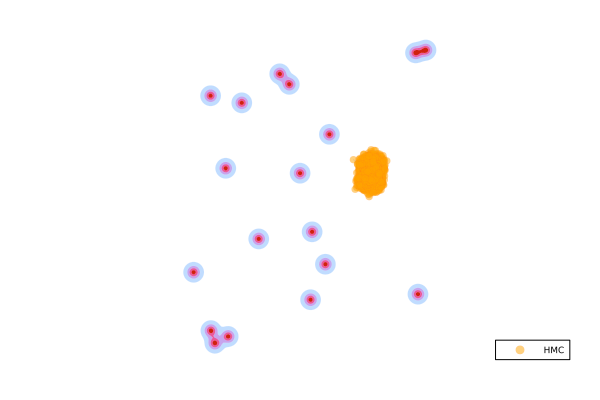

In [5]:
@time s1, a1 = mcmc(
    DualAverage(λ=2, δ=0.6),
    HMC(),
    model; n=1e4, n_burn=1e3,
    init = zeros(2)
)
x_hmc = s1[a1, :]
plt_hmc = scatterplot(plt(), x_hmc, label="HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:03:43
  HaRAM(0.034552982222117744, 579, 0.1646860581133143, Any[]):  0.7684463107378524


Acceptance Ratio = 0.7586
223.528095 seconds (1.00 G allocations: 74.648 GiB, 9.37% gc time, 0.49% compilation time)


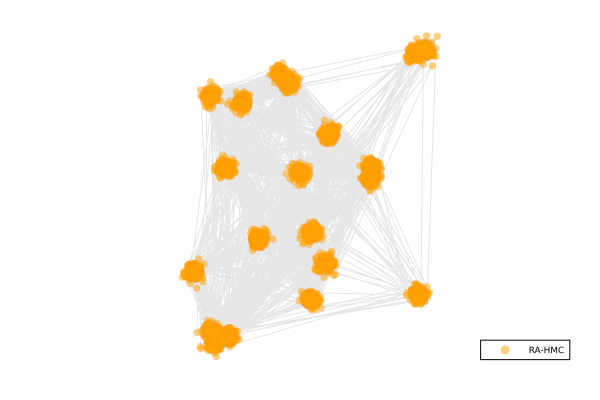

In [6]:
@time s2, a2 = mcmc(
    DualAverage(λ=20, δ=0.65),
    HaRAM(),
    model; n=5e3, n_burn=1e3,
    init = zeros(2)
)
x_haram = s2[a2, :]
plt_haram = scatterplot(plt(), x_haram |> m2t, label="RA-HMC")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  RAM(ZeroMeanIsoNormal(
dim: 2
μ: Zeros(2)
Σ: [4.0 0.0; 0.0 4.0]
)
, [-0.11436944474451104, 0.4486526718386479], Any[]):       0.13381103149475088


Acceptance Ratio = 0.1279
  2.090832 seconds (6.76 M allocations: 372.241 MiB, 4.78% gc time, 63.94% compilation time)


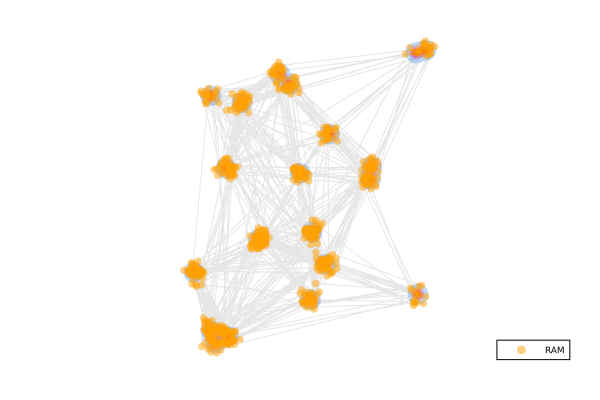

In [7]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(2, 2.0), z=randn(model.d)),
    model; n=5e3, n_burn=1e3,
    init = zeros(2)
)
x_ram = s3[a3, :]
plt_ram = scatterplot(plt(), x_ram |> m2t, label="RAM")

Progress: 100%|█████████████████████████████████████████| Time: 0:04:28
  PEHMC:  0.46684831970935514


Acceptance Ratio = 0.507
268.740567 seconds (902.71 M allocations: 38.635 GiB, 3.03% gc time, 12.65% compilation time)


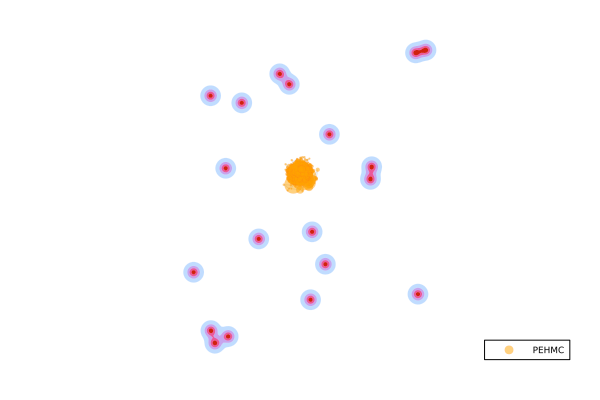

In [8]:
@time s4, w4, a4 = mcmc(
    PEHMC(ϵ=0.2, L=5, N=3),
    model; n=1e3, n_burn=1e2,
    init = zeros(2)
)
x_pehmc, w_pehmc = [s4[a4, :]...] |> a2m, [w4[a4, :]...]
plt_pehmc = scatterplot(plt(), x_pehmc |> m2t, ms=exp.(3 .* w_pehmc), label="PEHMC")